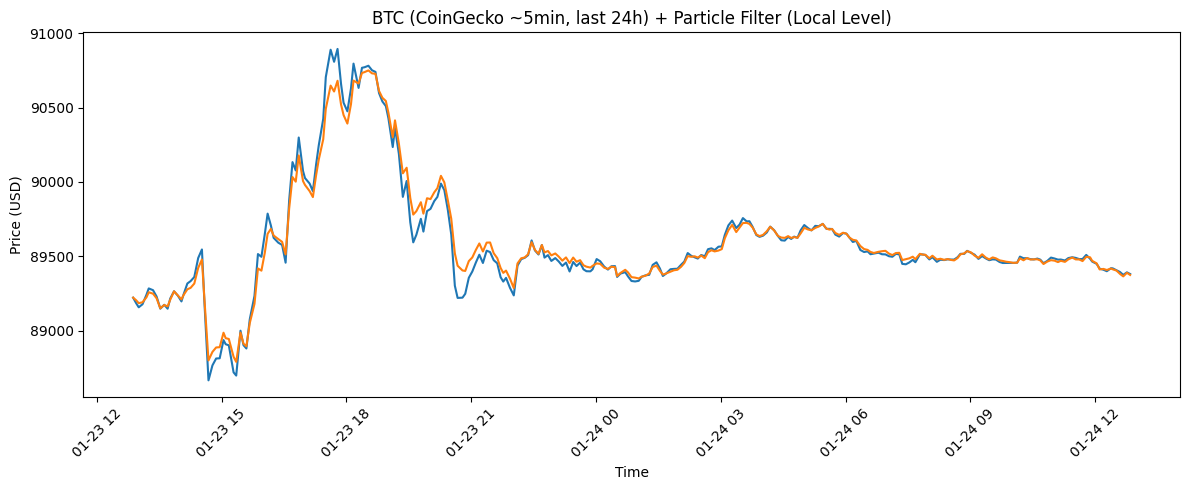

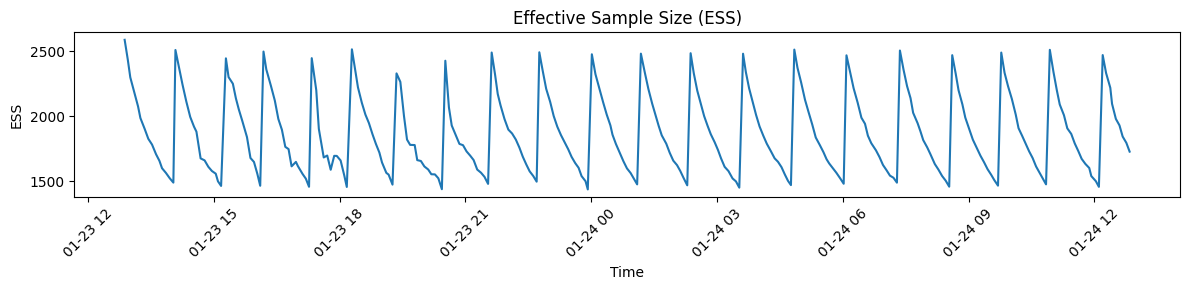

CSV saved: btc_24h_coingecko_pf_20260124-125141.csv


C:\Users\flare\AppData\Local\Temp\ipykernel_15184\585800057.py:156: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().strftime("%Y%m%d-%H%M%S")


In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -----------------------------
# 1) データ取得（CoinGecko: 直近1日, 約5分足）
# -----------------------------
def fetch_coingecko_btc_1day(vs="usd"):
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {"vs_currency": vs, "days": "1"}
    resp = requests.get(url, params=params, timeout=30)
    resp.raise_for_status()
    data = resp.json()

    df = pd.DataFrame(data["prices"], columns=["timestamp_ms", "price"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms")
    df = df.drop(columns=["timestamp_ms"]).sort_values("timestamp").reset_index(drop=True)
    return df

# -----------------------------
# 2) Bootstrap Particle Filter（ローカルレベルモデル）
# -----------------------------
def systematic_resample(weights, rng):
    """
    Systematic resampling.
    weights: shape (N,), sum to 1
    returns indices shape (N,)
    """
    N = len(weights)
    positions = (rng.random() + np.arange(N)) / N
    cumsum = np.cumsum(weights)
    idx = np.searchsorted(cumsum, positions)
    return idx

def bootstrap_particle_filter(y, N=2000, q=2e-5, r=5e-5, ess_threshold=0.5, seed=123):
    """
    y: observed log-price array shape (T,)
    N: number of particles
    q: process noise variance (state random walk)
    r: observation noise variance
    returns:
      x_filt_mean: filtered state mean (T,)
      x_filt_p10/p90: filtered quantiles (T,)
      ess: effective sample size (T,)
    """
    rng = np.random.default_rng(seed)
    T = len(y)

    # 初期分布：最初の観測周辺に置く（広すぎない程度）
    x = y[0] + rng.normal(0, np.sqrt(r), size=N)
    w = np.ones(N) / N

    x_mean = np.empty(T)
    x_p10 = np.empty(T)
    x_p90 = np.empty(T)
    ess_arr = np.empty(T)

    # 観測尤度（正規）をログで計算
    def loglik(y_t, x_particles):
        # y_t ~ N(x, r)
        return -0.5 * ((y_t - x_particles) ** 2) / r - 0.5 * np.log(2 * np.pi * r)

    for t in range(T):
        if t > 0:
            # 予測（状態遷移）
            x = x + rng.normal(0, np.sqrt(q), size=N)

        # 重み更新（対数で安定化）
        ll = loglik(y[t], x)
        ll -= ll.max()
        w = np.exp(ll)
        w_sum = w.sum()
        if w_sum == 0 or not np.isfinite(w_sum):
            # 退避：全滅したら一様に戻す
            w = np.ones(N) / N
        else:
            w /= w_sum

        # ESS（有効サンプルサイズ）
        ess = 1.0 / np.sum(w ** 2)
        ess_arr[t] = ess

        # フィルタ推定値（平均・分位点）
        x_mean[t] = np.sum(w * x)
        # 分位点は重み付きサンプルで近似（リサンプリング後でもOKだが、ここでは重み付きで近似）
        # 重み付き分位点：簡易に「重みで並べて累積」で求める
        order = np.argsort(x)
        x_sorted = x[order]
        w_sorted = w[order]
        cw = np.cumsum(w_sorted)
        x_p10[t] = x_sorted[np.searchsorted(cw, 0.10)]
        x_p90[t] = x_sorted[np.searchsorted(cw, 0.90)]

        # リサンプリング（ESSが閾値以下なら）
        if ess < ess_threshold * N:
            idx = systematic_resample(w, rng)
            x = x[idx]
            w = np.ones(N) / N

    return x_mean, x_p10, x_p90, ess_arr

# -----------------------------
# 3) 実行：取得→ログ変換→PF→可視化→保存
# -----------------------------
def main():
    df = fetch_coingecko_btc_1day(vs="usd")
    df["log_price"] = np.log(df["price"].astype(float))

    y = df["log_price"].to_numpy()

    # 粒子フィルタ（調整パラメータ）
    # q, r は「どれだけ滑らかにするか」のつまみ：
    #  - q を小さく → もっと滑らか（追従は遅くなる）
    #  - r を大きく → 観測がノイジー前提（より滑らか）
    x_mean, x_p10, x_p90, ess = bootstrap_particle_filter(
        y,
        N=3000,
        q=2e-5,
        r=5e-5,
        ess_threshold=0.5,
        seed=123
    )

    df["pf_log_mean"] = x_mean
    df["pf_log_p10"] = x_p10
    df["pf_log_p90"] = x_p90
    df["pf_mean_price"] = np.exp(df["pf_log_mean"])
    df["pf_p10_price"] = np.exp(df["pf_log_p10"])
    df["pf_p90_price"] = np.exp(df["pf_log_p90"])
    df["ess"] = ess

    # プロット（価格）
    plt.figure(figsize=(12, 5))
    plt.plot(df["timestamp"], df["price"])
    plt.plot(df["timestamp"], df["pf_mean_price"])
    plt.title("BTC (CoinGecko ~5min, last 24h) + Particle Filter (Local Level)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # プロット（ESS：フィルタがどれだけ重み退化しているか）
    plt.figure(figsize=(12, 3))
    plt.plot(df["timestamp"], df["ess"])
    plt.title("Effective Sample Size (ESS)")
    plt.xlabel("Time")
    plt.ylabel("ESS")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # CSV保存
    now = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
    out_csv = f"btc_24h_coingecko_pf_{now}.csv"
    df.to_csv(out_csv, index=False, encoding="utf-8")
    print("CSV saved:", out_csv)

if __name__ == "__main__":
    main()
